In [80]:
import os
import math
import json
import cv2

import numpy as np
import pprint as pp
import json as JSON
import pandas as pd
import pandas_gbq

from shapely.geometry import Point, Polygon
from dotenv import load_dotenv
from matplotlib import pyplot as plt

load_dotenv()

# ___MAPS IMAGES___ 

def saveImages(images_df):
    destination_table = 'osm_data.maps_images'
    pandas_gbq.to_gbq(images_df, project_id='sidhouses', destination_table=destination_table , if_exists='replace')

def loadImages():
    df = pandas_gbq.read_gbq('SELECT * FROM sidhouses.osm_data.maps_images')
    return df

# ___BUILDINGS___ 

def saveBuildings(buildings_df):
    destination_table = 'osm_data.buildings'
    buildings_df = buildings_df.drop(columns=['polygon','point'],axis=1)
    pandas_gbq.to_gbq(buildings_df, project_id='sidhouses', destination_table=destination_table , if_exists='replace')

def loadBuildings():
    df = pandas_gbq.read_gbq('SELECT * FROM sidhouses.osm_data.buildings')
    create_polygons(df)
    create_points(df)
    return df

# ___VILLAGES___ 

def saveVillages(village_df):
    destination_table = 'osm_data.villages'
    village_df = village_df.drop(columns=['polygon','point'],axis=1)
    pandas_gbq.to_gbq(village_df, project_id='sidhouses', destination_table=destination_table , if_exists='replace')

def loadVillages():
    df = pandas_gbq.read_gbq('SELECT * FROM sidhouses.osm_data.villages')
    create_polygons(df)
    create_points(df)
    return df

# --------- AUX ---------

def create_polygons(df):
  df['polygon'] = ""
  for index, row in df.iterrows():
    if (row['boundary_lon'] != '' and  row['boundary_lat'] != ''):
      lon = json.loads(row['boundary_lon'])
      lat = json.loads(row['boundary_lat'])
      df.at[index,'polygon'] = Polygon(zip(lon,lat))

def create_points(df):
  df['point'] = ""
  for index, row in df.iterrows():
    if (row['lat'] != '' and  row['lon'] != ''):
      p = Point(float(row['lon']) , float(row['lat']))
      df.at[index,'point'] = p 


def point_px_to_deg(lat, lon, image_row_ref):
    deg_per_px_lat = row_ref['deg_per_px_lat'][0]
    deg_per_px_lon = row_ref['deg_per_px_lon'][0]

    lat_deg = row_ref['lat_0'][0] - lat * deg_per_px_lat
    lon_deg = row_ref['lon_0'][0] + lon * deg_per_px_lon
    return lat_deg, lon_deg

def point_deg_to_px(lat, lon, image_row_ref):

    deg_per_px_lat = row_ref['deg_per_px_lat'][0]
    deg_per_px_lon = row_ref['deg_per_px_lon'][0]

    lat_px = (row_ref['lat_0'][0] - lat) / deg_per_px_lat
    lon_px = (row_ref['lon_0'][0] - lon) / deg_per_px_lon
    return lat_px, lon_px


In [8]:
# import data bases
images_df = loadImages()
buildings_df = loadBuildings()

Downloading: 100%|██████████| 402/402 [00:00<00:00, 2226.94rows/s]


              img_name    name  input_lat  input_lon  input_size  grid_size  \
0  Monnon_4_19_500.png  Monnon   9.842513   3.178864         500          4   

   zoom  lat_size  lon_size     lat_0     lon_0  m_per_px_lat  m_per_px_lon  \
0    19      1828      2000  9.844985  3.176123      0.294187      0.298123   

   deg_per_m_lat  deg_per_m_lon  deg_per_px_lat  deg_per_px_lon  
0       0.000009        0.00001        0.000003        0.000003  
935.5000000019193 -935.5000000020365


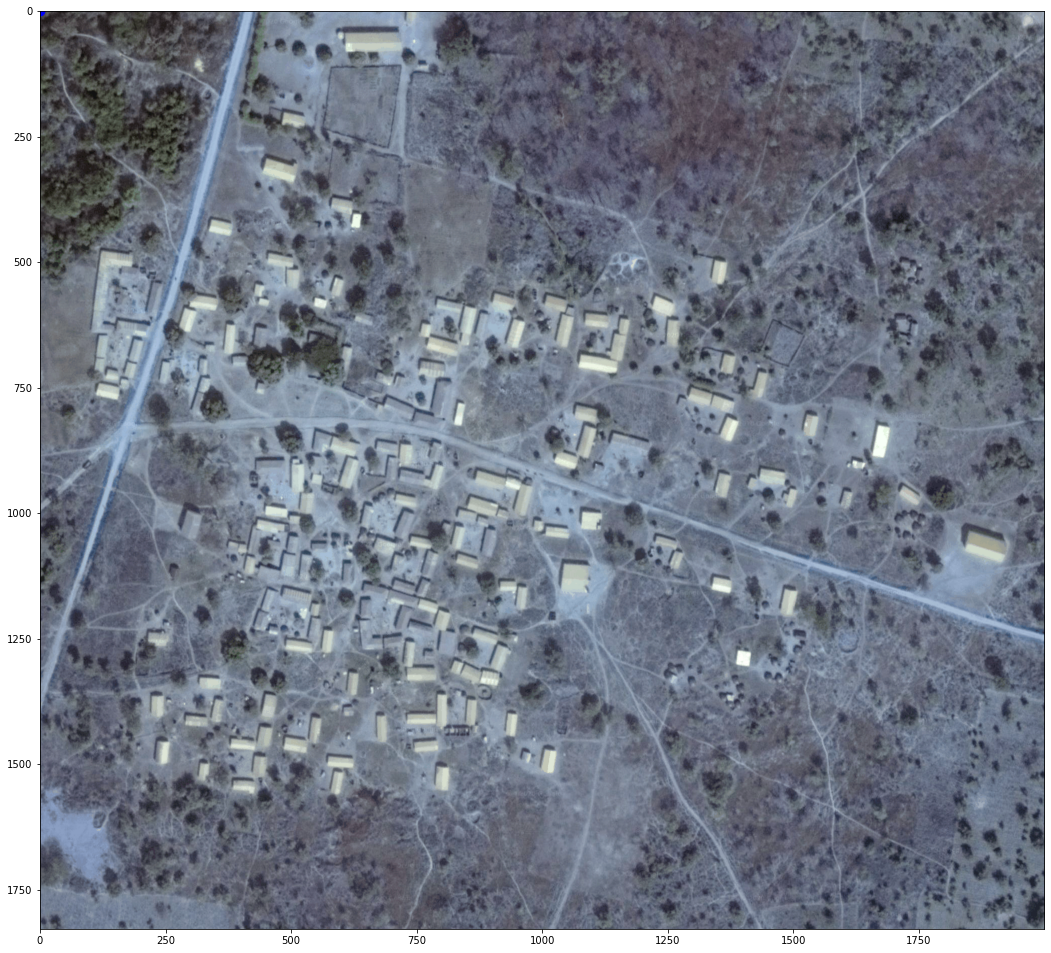

In [81]:
row_ref = images_df.loc[images_df['name'] == 'Monnon']

image_ref = './images/' + row_ref['img_name'][0]


circle1 = plt.Circle((0, 0), 10, color='b')

deg_per_px_lat = row_ref['deg_per_px_lat'][0]
deg_per_px_lon = row_ref['deg_per_px_lon'][0]

circle1 = plt.Circle((0, 0), 10, color='b')

lat_px, lon_px = point_deg_to_px( row_ref['input_lat'][0] , row_ref['input_lon'][0] , row_ref )

print(lat_px , lon_px)

circle2 = plt.Circle((lat_px, lon_px), 100, color='b')

img = cv2.imread(image_ref)
fig, ax = plt.subplots(figsize=(15, 185))
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.imshow(img)
